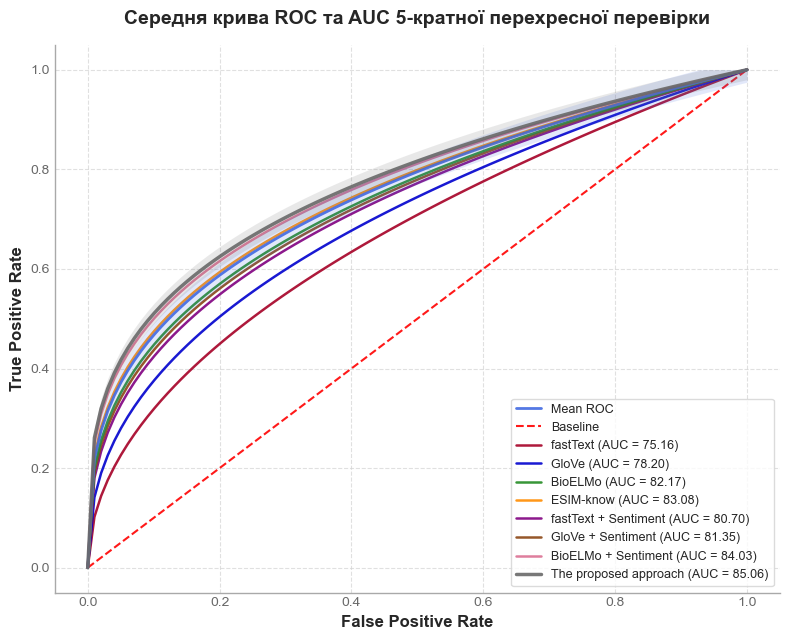

SVG file 'roc_auc_curves_recreated_convex.svg' has been generated.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager

# Try to use a common sans-serif font if available, otherwise default
try:
    plt.rcParams['font.sans-serif'] = 'Arial' # Or 'Helvetica', 'DejaVu Sans'
    plt.rcParams['font.family'] = 'sans-serif'
except:
    pass


# Model data: (Name, AUC, color, linestyle, optional: base_tpr_lift)
# base_tpr_lift is a heuristic to help shape the curves according to AUC
# Increase base_tpr_lift values for more convexity
models_data = [
    ("Baseline", 0.50, 'red', '--', 0.0), # AUC 50.00
    ("fastText (AUC = 75.16)", 75.16, '#a50026', '-', 0.35), # Dark Red
    ("GloVe (AUC = 78.20)", 78.20, '#0000CD', '-', 0.45), # Medium Blue
    ("fastText + Sentiment (AUC = 80.70)", 80.70, '#800080', '-', 0.55), # Purple
    ("GloVe + Sentiment (AUC = 81.35)", 81.35, '#8B4513', '-', 0.60), # Saddle Brown
    ("BioELMo (AUC = 82.17)", 82.17, '#228B22', '-', 0.65), # Forest Green
    ("ESIM-know (AUC = 83.08)", 83.08, '#FF8C00', '-', 0.70), # Dark Orange
    ("BioELMo + Sentiment (AUC = 84.03)", 84.03, '#DB7093', '-', 0.75), # PaleVioletRed
    ("The proposed approach (AUC = 85.06)", 85.06, '#696969', '-', 0.80), # Dim Gray
    ("Mean ROC", None, '#4169E1', '-', 0.68) # Royal Blue (visually in the middle)
]


# Define common FPR points - more points for smoother curves
fpr_common = np.linspace(0.0, 1.0, 100)

# Function to generate plausible TPR values based on AUC "lift"
# This is a heuristic to shape the curves. Higher lift = better curve (more convex).
def generate_tpr_convex(fpr, base_lift):
    if base_lift == 0.0: # Baseline
        return fpr

    # Using a power function: tpr = 1 - (1 - fpr)^(1 / (1 - lift_factor))
    # Or tpr = fpr^exponent, where exponent decreases with higher lift.
    # Let's use a modified power function that ensures (0,0) and (1,1)
    # and increases convexity with base_lift.
    # A simple approach: tpr = fpr ^ (1 - normalized_lift)
    # where normalized_lift is base_lift scaled to be between 0 and slightly less than 1.

    # For more convexity, we want the exponent to be smaller for higher lifts.
    # Let exponent = 1 / (1 + k * base_lift)
    # k controls how much effect base_lift has.
    k_convexity_factor = 3.0 # Increase this for more pronounced convexity difference
    
    # Add some small random variation to slightly differentiate curves with similar AUCs visually
    # This prevents perfect overlap if base_lifts are very close.
    noise_factor = base_lift * 0.05 # Small noise proportional to lift
    effective_lift = base_lift + np.random.uniform(-noise_factor, noise_factor)

    if effective_lift > 0:
        # Exponent must be < 1 for convexity towards top-left.
        # Exponent closer to 0 means more convex.
        # Max exponent close to 1 (for low lift), min exponent closer to 0 (for high lift).
        exponent = 1.0 / (1.0 + k_convexity_factor * effective_lift)
        # Ensure exponent is within a reasonable range (e.g., 0.1 to 0.99)
        exponent = np.clip(exponent, 0.1, 0.99)
        tpr = fpr**exponent
    else: # Baseline
        tpr = fpr

    # Ensure sorted and within [0,1]
    tpr = np.sort(np.clip(tpr, 0, 1))
    tpr[0] = 0.0
    tpr[-1] = 1.0
    # Ensure monotonicity after noise (if any) - this might not be strictly needed with the power func
    for i in range(1, len(tpr)):
        if tpr[i] < tpr[i-1]:
            tpr[i] = tpr[i-1]
    return tpr


plt.style.use('seaborn-v0_8-whitegrid') # Start with a style
fig, ax = plt.subplots(figsize=(8, 6.5)) # Slightly adjusted for better legend fit

# Customizing to match the original image more closely
ax.set_facecolor('white')
ax.grid(True, linestyle='--', color='lightgray', alpha=0.7)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_color('darkgrey')


line_widths = {
    "The proposed approach (AUC = 85.06)": 2.5,
    "Mean ROC": 2.0,
    "Baseline": 1.5
}
default_lw = 1.8

zorders = {
    "Baseline": 1,
    "The proposed approach (AUC = 85.06)": 10, # On top
    "Mean ROC": 9
}
default_zorder = 5


# Order for plotting curves (generally from lowest AUC to highest for better visual layering)
# but specifically matching the legend order if that's the goal for visual consistency.
# Original image legend order: Mean ROC, Baseline, fastText, GloVe, BioELMo, ESIM-know, fastText+S, GloVe+S, BioELMo+S, Proposed
ordered_plot_names = [
    "Baseline",
    "fastText (AUC = 75.16)",
    "GloVe (AUC = 78.20)",
    "fastText + Sentiment (AUC = 80.70)",
    "GloVe + Sentiment (AUC = 81.35)",
    "BioELMo (AUC = 82.17)",
    "ESIM-know (AUC = 83.08)",
    "BioELMo + Sentiment (AUC = 84.03)",
    "Mean ROC", # Mean ROC is often plotted on top of many
    "The proposed approach (AUC = 85.06)" # Proposed usually last/top
]

final_plot_order_data = []
for name in ordered_plot_names:
    final_plot_order_data.append(next(m for m in models_data if m[0] == name))


for i, (name, auc_score, color, linestyle, base_tpr_lift) in enumerate(final_plot_order_data):
    tpr_values = generate_tpr_convex(fpr_common, base_tpr_lift)
    
    fill_alpha = 0.15
    line_alpha = 0.9 # Default line alpha
    
    current_lw = line_widths.get(name, default_lw)
    current_zorder = zorders.get(name, default_zorder)

    label_text = name
    
    ax.plot(fpr_common, tpr_values, color=color, linestyle=linestyle, lw=current_lw, label=label_text, alpha=line_alpha, zorder=current_zorder)

    # Shaded areas for Mean ROC and Proposed Approach
    shade_offset = 0.025 # How much the shade extends
    if name == "Mean ROC":
        tpr_upper = np.clip(tpr_values + shade_offset, 0, 1)
        tpr_lower = np.clip(tpr_values - shade_offset, 0, 1)
        for k in range(1, len(tpr_upper)): tpr_upper[k] = max(tpr_upper[k], tpr_upper[k-1])
        for k in range(1, len(tpr_lower)): tpr_lower[k] = max(tpr_lower[k], tpr_lower[k-1])
        tpr_lower = np.minimum(tpr_lower, tpr_values)
        tpr_upper = np.maximum(tpr_upper, tpr_values)
        ax.fill_between(fpr_common, tpr_lower, tpr_upper, color=color, alpha=fill_alpha, zorder=current_zorder-0.5, linewidth=0) # linewidth=0 for fill_between
    elif name == "The proposed approach (AUC = 85.06)":
        tpr_upper = np.clip(tpr_values + shade_offset*0.8, 0, 1) # Slightly smaller shade for proposed
        tpr_lower = np.clip(tpr_values - shade_offset*0.8, 0, 1)
        for k in range(1, len(tpr_upper)): tpr_upper[k] = max(tpr_upper[k], tpr_upper[k-1])
        for k in range(1, len(tpr_lower)): tpr_lower[k] = max(tpr_lower[k], tpr_lower[k-1])
        tpr_lower = np.minimum(tpr_lower, tpr_values)
        tpr_upper = np.maximum(tpr_upper, tpr_values)
        ax.fill_between(fpr_common, tpr_lower, tpr_upper, color=color, alpha=fill_alpha, zorder=current_zorder-0.5, linewidth=0)


# Title and labels
ax.set_title("Середня крива ROC та AUC 5-кратної перехресної перевірки", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("False Positive Rate", fontsize=12, fontweight='bold')
ax.set_ylabel("True Positive Rate", fontsize=12, fontweight='bold')

# Axis limits and ticks
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.tick_params(axis='both', which='major', labelsize=10, colors='dimgray')


# Legend - order as in the original image
handles, labels = ax.get_legend_handles_labels()
legend_order_names = [
    "Mean ROC",
    "Baseline",
    "fastText (AUC = 75.16)",
    "GloVe (AUC = 78.20)",
    "BioELMo (AUC = 82.17)",
    "ESIM-know (AUC = 83.08)",
    "fastText + Sentiment (AUC = 80.70)",
    "GloVe + Sentiment (AUC = 81.35)",
    "BioELMo + Sentiment (AUC = 84.03)",
    "The proposed approach (AUC = 85.06)"
]
ordered_handles = []
ordered_labels = []
for name in legend_order_names:
    try:
        idx = labels.index(name) # This gets the index from the *current* plot order of labels
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels[idx])
    except ValueError:
        print(f"Warning: Label '{name}' not found for legend ordering (current labels: {labels}).")


ax.legend(ordered_handles, ordered_labels, loc='lower right', fontsize=9, frameon=True, facecolor='white', edgecolor='lightgray')


plt.tight_layout()
plt.savefig("ch_paper_6.svg", format="svg", bbox_inches='tight')
plt.show()

print("SVG file 'roc_auc_curves_recreated_convex.svg' has been generated.")